### **Face Detection: MTCNN**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from datetime import datetime


%config InlineBackend.figure_format = 'svg'

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

In [3]:
import tensorflow as tf
from tensorflow import keras
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### **Introduction**

![](./img/fig1.jpg)

### **人脸识别的方法**

**1. 基于知识的方法**

基于知识的方法的具体含义就是编写各种规则，这些规则的编写根据就是人脸模式的先于经验的知识，之后再进行下一步的人脸检测。
- **灰度分布特征：** 灰度值是反应人脸图像亮度信息的一个变量，不同的人脸器官分布一般不同，从而导致人脸面部各区域的灰度分布特征也不同。所以，可以考虑从灰度分布特征入手，建立一些规则，利用这些规则在人脸图像当中的呈现状态来确定图像当中有无人脸。
- **结构特征：** 结构特征对于我们人脸来说是比较明显的，首先对称性就是一个很明显的结构特征。
- **纹理特征：** 由于人脸纹理特征的特殊性，可以用来进行人脸检测，但有一定缺陷：例如处理多视角问题比较有难度。
- **肤色特征：** 肤色相对于人脸的其他特征来讲是一种比较可靠和稳定的人脸特征，人脸的肤色特征是与非人脸相区分的一个显著特征。人脸的肤色不同主要还是亮度不同，人脸出现旋转、表情、姿态等变化时，肤色特征还是比较稳定的，而且它还能很容易地区别于大多数背景物体相区别，总体来说比较可靠稳定，比较常用。
- **形状和轮廓特征：** 人脸的边缘特征比较典型，可以利用他们进行特征提取。特征提取的第一步就是进行边缘检测，边缘检测有许多算子，比如：Sobel算 子、Prewitt算子、Canny算子、Roberts Cross算子等。

**2. 基于模板匹配的方法**

模板和图像之间存在一定的自相关性，自相关性的强弱就可以反映该图像是否有可能为人脸图像。

* **固定模板匹配：** 固定模板匹配是指预先设定一个阈值，将人脸五官位置的比例关系做成固定模板，用该模板逐点扫描匹配候选人脸图像，并计算该模板与输入图像的各区域在人脸的各个区域如人脸边界、眼睛、鼻子和嘴等部位的相关程度，由相关程度的大小来决定该图像是否为人脸图像，若计算出的相关程度超出了预先设定的阈值，说明检测到人脸，否则为非人脸 图像 。
* **可变模板匹配：** 可变模板的构成要素是一个参数可调的器官模板和与之相应的能量函数，此器官模板是根据被测物体形状设计而成的，能量函数设计的主要依据就是图像的灰度信息，同时，一些先验知识也需要用到，比如被测物体的轮廓等。

**3. 基于统计模型的方法**

* **本征脸：** 通过代数运算的降维方法在人脸图像的特征空间进行降维，以便于计算人脸图像的特征值和特征向量。通过观察图像的代数特征信息，寻找人脸和非人脸这两种模式在所得的低维特征空间的分布规律。常用的降维方法主要是PCA(主成分分析法)。
* **基于人工神经网络的方法：** 人工神经网络具有自适应、自组织、和实时性等优点，可以对复杂的、难以显示描述的模式识别进行很好的处理。
* **基于支持向量机的方法：** 支持向量机方法有效地将较少的样本信息、复杂的模型及较强的学习能力三者融合，以获得最好的推广能力。支持向量机的关键之处就是：超平面的有效建立，在这个超平面当中使正样本和负样本的分隔边界最大化。用于人脸检测的速度也很快。
* **基于AdaBoost算法的方法：** Adaboost 是一种迭代算法，其核心思想是针对同一训练集训练不同的分类器（弱分类器），然后把这些弱分类器集合起来，构成一个更强的最终分类器（强分器）, 其算法本身是通过改变数据分布来实现的，它根据每次训练集之中每个样本的分类是否正确，以及上次总体分类的准确率，来确定每个样本的权值。将修改过权值的新数据集送给下层分类器进行训练，最后将每次训练得到的分类器融合起来，作为最后的决策分类器。使用 Adaboost 分类器可以排除一些不 必要的训练数据特征并将重心放在关键的技术上。运用 Adaboost 算法训练所得的最终强分类器错误率很低，效率也比较高，得到了广泛的应用。

#### **PCA+SVM**

In [4]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# 打印进度
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [5]:
# 使用简单的sklearn内置LFW数据集试验
# 13233张人脸图像，每张图像均给出对应的人名，共有5749人，且绝大部分人仅有一张图片

# 获取数据集时，要求获取到的每个人都至少有70张人脸图像
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# 获取这个数据集的图片的大小
n_samples, h, w = lfw_people.images.shape

# X就是人脸的数据
X = lfw_people.data
n_features = X.shape[1]

# y是对应的标签
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
# 使用了7个人的1288张图片，每张图片的像素值为50*37=1850
print(h)
print(w)
print(h * w)

2022-04-04 01:03:05,191 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2022-04-04 01:03:07,602 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2022-04-04 01:03:10,031 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2022-04-04 01:03:19,886 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
50
37
1850


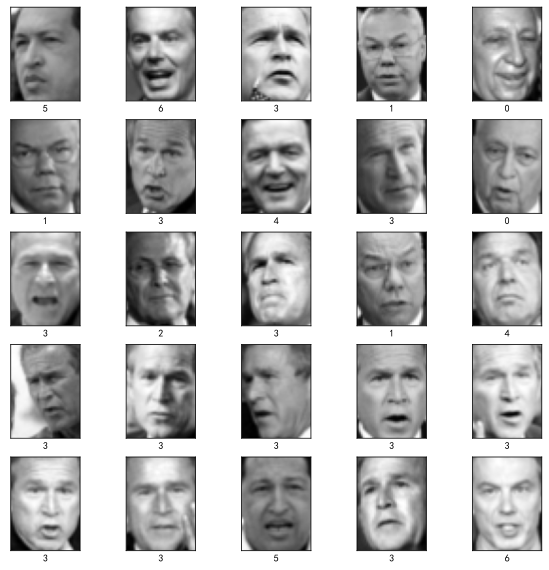

In [6]:
# 画出部分图片
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # cmap='gray'，显示灰度图
    # 转成h*w的宽乘以高的数据格式
    plt.imshow(X[i].reshape((h, w)), cmap='gray')
    plt.xlabel(y[i])
plt.show()

In [7]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Feature extraction
# 使用PCA提取150列，原先有一千多列，直接SVM的话内存会炸
n_components = 150
print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))
eigenfaces = pca.components_.reshape((n_components, h, w))

eigenfaces.shape

# 输入特征转换
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

print(X_train_pca.shape)
print(X_test_pca.shape)

Extracting the top 150 eigenfaces from 966 faces
done in 2.200s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.013s
(966, 150)
(322, 150)


In [8]:
# 每一张图片表示成了一个长度为150的向量
print(X_train_pca[0])

[-2.0756013  -1.0457909   2.1269336   0.03682837 -0.7575716  -0.5173672
  0.8555053   1.0519345   0.45774615  0.01347858 -0.03963187  0.6387286
  0.48167714  2.3378534   1.7784591   0.1330792  -2.2713258  -4.456944
  2.0976667  -1.1379303   0.18844537 -0.33497196  1.1254517  -0.3240306
  0.14095695  1.0769459   0.758824   -0.09977009  3.1199503   0.8838141
 -0.8934021   1.1596006   1.4306604   1.6855984   1.3434956  -1.2590735
 -0.639165   -2.3363106  -0.01366346 -1.4638196  -0.468875   -1.054757
 -1.3328041   1.1365445   2.2222366  -1.8015335  -0.30637333 -1.0282669
  4.7733502   3.4601016   1.9259669  -1.3514746  -0.2588509   2.0100808
 -1.0564686   0.3610552   1.1703819   0.75693566  0.9005496   0.5990454
 -0.46522775  2.097981    1.3449012   1.932371    5.066915   -0.7065046
  0.60464025 -0.8982773  -0.21738707 -2.1074498  -1.6849287  -0.19552629
 -1.748794   -3.0549238   2.0559657   0.39414194  0.13138817  1.2121865
 -0.7945395  -1.3862154  -2.0293415  -2.7857094   1.4870256   0.2

In [9]:
# SVM
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 10.182s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)


In [10]:
from sklearn.metrics import confusion_matrix

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

Predicting people's names on the test set
done in 0.032s


In [12]:
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.47      0.69      0.56        13
     Colin Powell       0.75      0.83      0.79        60
  Donald Rumsfeld       0.63      0.63      0.63        27
    George W Bush       0.90      0.89      0.89       146
Gerhard Schroeder       0.91      0.84      0.87        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.93      0.78      0.85        36

         accuracy                           0.82       322
        macro avg       0.77      0.75      0.76       322
     weighted avg       0.83      0.82      0.82       322



* precision：精确率，预测正确的样本个数占总的正类预测个数的比例（从预测结果角度看，有多少预测是准确的）
* recall: 召回率，确定了正类被预测为正类图片占所有标注图片的个数（从标注角度看，有多少被召回）
* f1-score: 是precision和recall调和平均值。

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

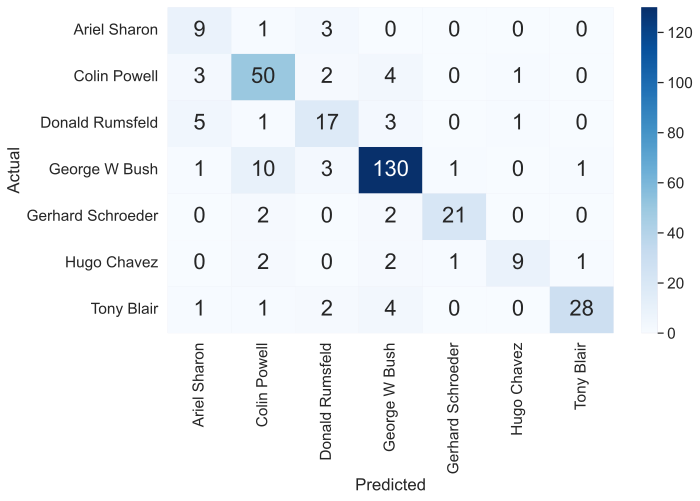

In [15]:
target_names
y_test_names = [target_names[i] for i in y_test]
y_pred_names = [target_names[i] for i in y_pred]
data = confusion_matrix(y_test_names, y_pred_names)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_names), index = np.unique(y_test_names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10, 6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 22}) 

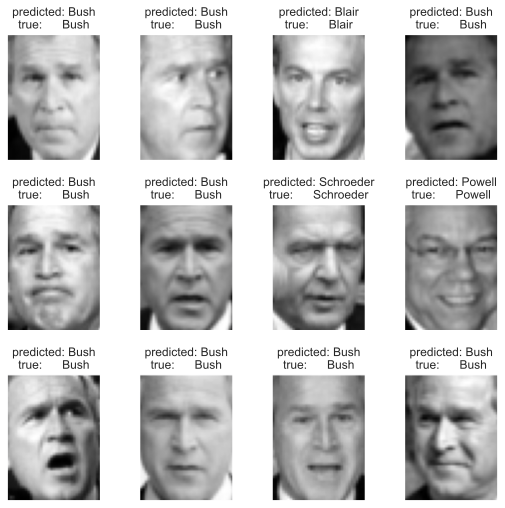

In [16]:
# 画出12张图片看下分类的结果是否准确
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

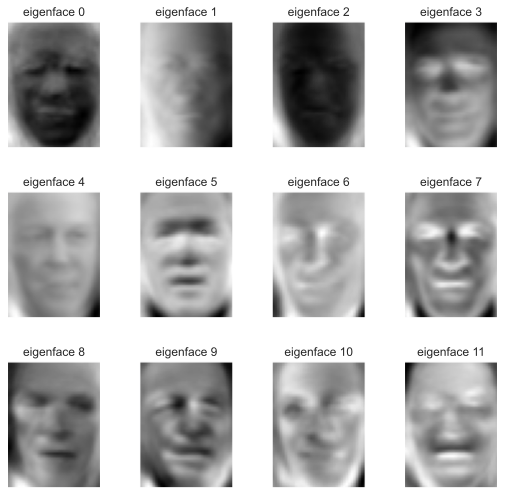

In [17]:
# 可视化特征脸，画出降维后得到的特征脸
# 比较模糊，但是就相当于降维得到的人脸的模版
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

#### **CNN**

In [18]:
# 数据格式的转换
# 而是需要将他们转成(样本数，高，宽，通道数)的格式，作为卷积神经网络模型的输入
X_train = X_train.reshape((X_train.shape[0], h, w, 1))
X_test = X_test.reshape((X_test.shape[0], h, w, 1))
print(X_train.shape)
print(X_test.shape)

(966, 50, 37, 1)
(322, 50, 37, 1)


In [19]:
# 尝试简单的CNN模型
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Flatten, Conv2D, MaxPool2D

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (h, w, 1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation = "softmax"))
model.compile(optimizer='adam' , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 37, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 37, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 18, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 18, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 18, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 18, 64)        36928     
                                                        

In [20]:
# train
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
31/31 [==============================] - 6s 21ms/step - loss: 6.3049 - accuracy: 0.3240
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 1.6285 - accuracy: 0.4089
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 1.4384 - accuracy: 0.4917
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 1.1509 - accuracy: 0.6014
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 0.9855 - accuracy: 0.6563
Epoch 6/100
31/31 [==============================] - 0s 13ms/step - loss: 0.8078 - accuracy: 0.7236
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 0.6918 - accuracy: 0.7495
Epoch 8/100
31/31 [==============================] - 0s 13ms/step - loss: 0.5291 - accuracy: 0.8178
Epoch 9/100
31/31 [==============================] - 0s 13ms/step - loss: 0.4576 - accuracy: 0.8364
Epoch 10/100
31/31 [==============================] - 0s 13ms/step - loss: 0.4814 - accuracy: 0.8313

In [22]:
# fit
y_pred = model.predict(X_test)
y_pred = np.array([np.argmax(i) for i in y_pred])
y_pred.shape
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.77      0.71        13
     Colin Powell       0.97      0.93      0.95        60
  Donald Rumsfeld       0.95      0.78      0.86        27
    George W Bush       0.95      0.99      0.97       146
Gerhard Schroeder       0.95      0.76      0.84        25
      Hugo Chavez       0.92      0.80      0.86        15
       Tony Blair       0.81      0.94      0.87        36

         accuracy                           0.92       322
        macro avg       0.89      0.85      0.87       322
     weighted avg       0.92      0.92      0.92       322



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

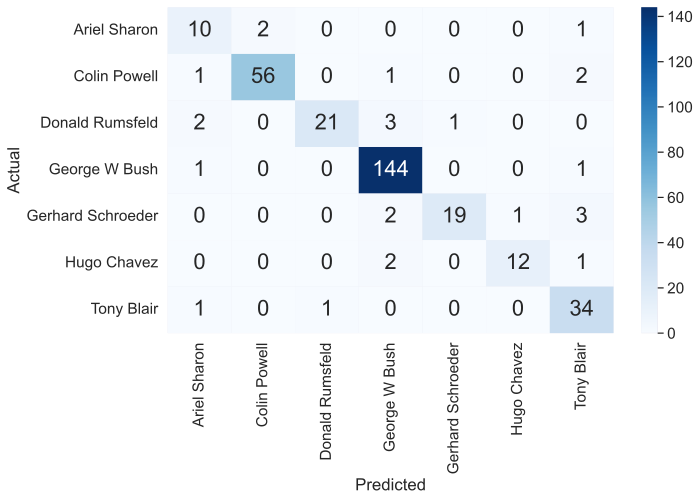

In [25]:
# confusion matrix
y_test_names = [target_names[i] for i in y_test]
y_pred_names = [target_names[i] for i in y_pred]
data = confusion_matrix(y_test_names, y_pred_names)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_names), index = np.unique(y_test_names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10, 6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 22})

#### **基于Haar特征的人脸检测实现**

Haar-like特征最早是由Papageorgiou等应用于人脸表示，在2001年，Viola和Jones两位大牛发表了经典的《Rapid Object Detection using a Boosted Cascade of Simple Features》和《Robust Real-Time Face Detection》，在AdaBoost算法的基础上，使用Haar-like小波特征和积分图方法进行人脸检测，他俩不是最早使用提出小波特征的，但是他们设计了针对人脸检测更有效的特征，并对AdaBoost训练出的强分类器进行级联。这可以说是人脸检测史上里程碑式的一笔了，也因此当时提出的这个算法被称为Viola-Jones检测器。又过了一段时间，Rainer Lienhart和Jochen Maydt两位大牛将这个检测器进行了扩展，最终形成了OpenCV现在的Haar分类器。

**Haar-like特征**
- Haar(哈尔)特征分为三类：边缘特征、线性特征、中心特征和对角线特征，组合成特征模板。特征模板内有白色和黑色两种矩形，并定义该模板的特征值为白色矩形像素和减去黑色矩形像素和。Haar特征值反映了图像的灰度变化情况。例如：脸部的一些特征能由矩形特征简单的描述，例如眼睛要比脸颊颜色要深，鼻梁两侧比鼻梁颜色要深，嘴巴比周围颜色要深等。
- 通过改变特征模板的大小和位置，可在图像子窗口中穷举出大量的特征。上图的特征模板称为“特征原型”；特征原型在图像子窗口中扩展（平移伸缩）得到的特征称为“矩形特征”；矩形特征的值称为“特征值”。

![](./img/fig2.png)

- 上图中两个矩形特征，表示出人脸的某些特征。比如中间一幅表示眼睛区域的颜色比脸颊区域的颜色深，右边一幅表示鼻梁两侧比鼻梁的颜色要深。同样，其他目标，如眼睛等，也可以用一些矩形特征来表示。使用特征比单纯地使用像素点具有很大的优越性，并且速度更快。

- 矩形特征可位于图像任意位置，大小也可以任意改变，所以矩形特征值是矩形模版类别、矩形位置和矩形大小这三个因素的函数。故类别、大小和位置的变化，使得很小的检测窗口含有非常多的矩形特征，如：在24*24像素大小的检测窗口内矩形特征数量可以达到16万个。这样就有两个问题需要解决了：

（1）如何快速计算那么多的特征？通过积分图的方式。

积分图就是只遍历一次图像就可以求出图像中所有区域像素和的快速算法，大大的提高了图像特征值计算的效率。

积分图主要的思想是**将图像从起点开始到各个点所形成的矩形区域像素之和作为一个数组的元素保存在内存中，当要计算某个区域的像素和时可以直接索引数组的元素，不用重新计算这个区域的像素和，从而加快了计算（即动态规划算法）**。积分图能够在多种尺度下，使用相同的时间（常数时间）来计算不同的特征，因此大大提高了检测速度。

（2）哪些矩形特征才是对分类器分类最有效的？通过AdaBoost算法来训练。

我们可以先筛选出T个优秀的特征值（即最优弱分类器）；将这个T个最优弱分类器传给AdaBoost进行训练。

#### **OpenCV**

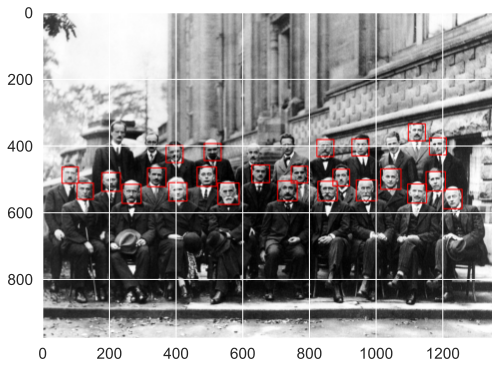

In [27]:
# 安装了opencv-python之后，可以在anaconda的site-packages里面cv2的data子文件夹中找到对应的配置文件
# 使用haarcascade_frontalface_default.xml作为演示。这些xml文件定义了OpenCV中使用的决策树模型的结构
# 看文件名称可以看到其中有一些适用于检测人脸、眼睛、鼻子和嘴等部位的跟踪，这些文件需要正面、直立的人体图像
import cv2

# 这个玩意还需要转换成灰度图才能检测

def StaticDetect(filename):
    # 定义xml文件位置
    haar_front_face_xml = './model/haarcascade_frontalface_default.xml'
    
    # 创建一个级联分类器 加载一个 .xml 分类器文件
    # 它既可以是Haar特征也可以是其他特征，例如LBP特征的分类器
    face_cascade = cv2.CascadeClassifier(haar_front_face_xml)

    # 加载图像
    img = cv2.imread(filename)
    # 转换为灰度图
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 进行人脸检测，传入scaleFactor，minNegihbors，
    # 分别表示人脸检测过程中每次迭代时图像的压缩率以及
    # 每个人脸矩形保留近似数目的最小值
    # 返回人脸矩形数组
    faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
    for (x, y, w, h) in faces:
        # 在原图像上绘制矩形
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    
# 使用一组图片进行尝试
filename = './img/fig4.jpg'
StaticDetect(filename)

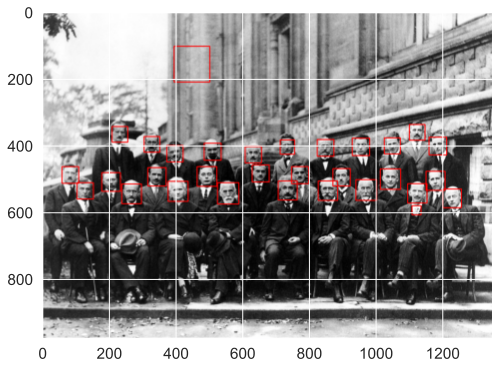

In [29]:
# 检测方法可以工作，但是结果并不完美
# 将scaleFactor修改为1.1
# 调整scalefactor，也就是压缩的比例
def StaticDetect(filename):
    # 定义xml文件位置
    haar_front_face_xml = './model/haarcascade_frontalface_default.xml'
    
    # 创建一个级联分类器 加载一个 .xml 分类器文件
    # 它既可以是Haar特征也可以是其他特征，例如LBP特征的分类器
    face_cascade = cv2.CascadeClassifier(haar_front_face_xml)

    # 加载图像
    img = cv2.imread(filename)
    # 转换为灰度图
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 进行人脸检测，传入scaleFactor，minNegihbors，
    # 分别表示人脸检测过程中每次迭代时图像的压缩率以及
    # 每个人脸矩形保留近似数目的最小值
    # 返回人脸矩形数组
    faces = face_cascade.detectMultiScale(gray_img, 1.1, 5)
    for (x, y, w, h) in faces:
        # 在原图像上绘制矩形
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)

filename = './img/fig4.jpg'
StaticDetect(filename)

# 这次我们没有错过任何一张人脸，但是却在图片的上面出现了误检

#### **基于MTCNN+FaceNet+SVM的人脸检测**

使用MTCNN模型进行人脸检测，使用FaceNet模型为每个检测到的人脸创建人脸嵌入，然后我们将开发一个线性支持向量机分类器模型来预测给定人脸的身份

作为演示，我们使用一个包含名人照片的小型数据集：5 Celebrity Faces Dataset。数据集已经放在了data文件夹下的train和vali子文件夹中，包含了5个名人的少量图片。这些照片提供了各种方向、光照和各种大小的人脸。重要的是，每张照片都包含一张人脸。我们将使用这个数据集作为分类器的基础，仅对 train 数据集进行训练，并对 val 数据集中的人脸进行分类

**MTCNN模型介绍**

使用多任务级联卷积神经网络（Multi-Task Cascaded Convolutional Neural Network，MTCNN）进行人脸检测，例如，从照片中查找并提取人脸。这是一种最先进的人脸检测深度学习模型，在 2016 年发表的论文《使用多任务级联卷积网络的联合人脸检测与对齐》（ Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks ）有所描述。

MTCNN算法包含三个子网络：Proposal Network(P-Net)、Refine Network(R-Net)、Output Network(O-Net)，这三个网络对人脸的处理依次从粗到细。

在使用这三个子网络之前，需要使用图像金字塔将原始图像缩放到不同的尺度，然后将不同尺度的图像送入这三个子网络中进行训练，目的是为了可以检测到不同大小的人脸，从而实现多尺度目标检测。

其实就是算法的三个子网络要求的输入大小是一定的，需要是12\*12\*3的形状，但是你照片当中的人脸的大小显然是有大有小的，所以需要缩放。输入后特征检验从粗到细。

**P-Net网络**
- P-Net的主要目的是为了生成一些候选框，我们通过使用P-Net网络，对图像金字塔图像上不同尺度下的图像的每一个12×12区域都做一个人脸检测(实际上在使用卷积网络实现时，一般会把一张h×w的图像送入P-Net中，最终得到的特征图每一点都对应着一个大小为12×12的感受野，但是并没有遍历全一张图像每一个12×12的图像)。
- P-Net的输入是一个12×12×3的RGB图像，在训练的时候，该网络要判断这个12×12的图像中是否存在人脸，并且给出人脸框的回归和人脸关键点定位；
- 在测试的时候输出只有N个边界框的4个坐标信息和score，当然这4个坐标信息已经使用网络的人脸框回归进行校正过了，score可以看做是分类的输出(即人脸的概率)：
- 网络的第一部分输出是用来判断该图像是否包含人脸，输出向量大小为1×1×2，也就是两个值，即图像是人脸的概率和图像不是人脸的概率。这两个值加起来严格等于1，之所以使用两个值来表示，是为了方便定义交叉熵损失函数。
- 网络的第二部分给出框的精确位置，一般称为框回归。P-Net输入的12×12的图像块可能并不是完美的人脸框的位置，如有的时候人脸并不正好为方形，有可能12×12的图像偏左或偏右，因此需要输出当前框位置相对完美的人脸框位置的偏移。这个偏移大小为1×1×4，即表示框左上角的横坐标的相对偏移，框左上角的纵坐标的相对偏移、框的宽度的误差、框的高度的误差。
- 网络的第三部分给出人脸的5个关键点的位置。5个关键点分别对应着左眼的位置、右眼的位置、鼻子的位置、左嘴巴的位置、右嘴巴的位置。每个关键点需要两维来表示，因此输出是向量大小为1×1×10。

**R-Net**

由于P-Net的检测时比较粗略的，所以接下来使用R-Net进一步优化。R-Net和P-Net类似，不过这一步的输入是前面P-Net生成的边界框，不管实际边界框的大小，在输入R-Net之前，都需要缩放到24×24×3。网络的输出和P-Net是一样的。这一步的目的主要是为了去除大量的非人脸框。


**O-Net**

进一步将R-Net的所得到的区域缩放到48×48×3，输入到最后的O-Net，O-Net的结构与P-Net类似，只不过在测试输出的时候多了关键点位置的输出。输入大小为48×48×3的图像，输出包含P个边界框的坐标信息，score以及关键点位置。

从P-Net到R-Net，再到最后的O-Net，网络输入的图像越来越大，卷积层的通道数越来越多，网络的深度也越来越深，因此识别人脸的准确率应该也是越来越高的。同时P-Net网络的运行速度越快，R-Net次之、O-Net运行速度最慢。之所以使用三个网络，是因为一开始如果直接对图像使用O-Net网络，速度会非常慢。实际上P-Net先做了一层过滤，将过滤后的结果再交给R-Net进行过滤，最后将过滤后的结果交给效果最好但是速度最慢的O-Net进行识别。这样在每一步都提前减少了需要判别的数量，有效地降低了计算的时间。

**Loss Function for MTCNN**

由于MTCNN包含三个子网络，因此其损失函数也由三部分组成。针对人脸识别问题，直接使用交叉熵代价函数，对于框回归和关键点定位，使用L2损失。最后把这三部分的损失各自乘以自身的权重累加起来，形成最后的总损失。在训练P-Net和R-Net的时候，我们主要关注目标框的准确度，而较少关注关键点判定的损失，因此关键点损失所占的权重较小。对于O-Net，比较关注的是关键点的位置，因此关键点损失所占的权重就会比较大。

In [30]:
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [34]:
# 使用mtcnn库创建人脸检测器并提取人脸，以便在后续部分中与FaceNet人脸检测器模型一起使用
# 定义函数extract_face()从加载的文件名加载照片，并返回提取的人脸。它假定照片包含一张人脸，并将返回检测到的第一张人脸
from PIL import Image
from mtcnn.mtcnn import MTCNN
 
# 从一张给定的图像中提取一张人脸

# 这里刚好相反，前面那种方法只能搞黑白，所以还要把彩色图转成黑白，而这里MTCNN反倒需要把黑白转成彩色 
def extract_face(filename,  required_size=(160,  160)):
    # 读取图片，以NumPy数组的形式加载图像
    image = Image.open(filename)
    # 转换为RGB格式，以防图像出现alpha通道或变成黑白
    image = image.convert('RGB')
    # 转换为数组
    pixels = np.asarray(image)
    # 利用默认的权重定义检测器
    detector = MTCNN()
    # 检测图片中的人脸
    results = detector.detect_faces(pixels)
    # print(results)
    # 结果是一个边界框列表，其中每个边界框定义了边界框的左下角，以及宽度和高度
    # 如果我们假设照片中只有一张人脸用于实验，那我们就取出第一个边界框
    x1, y1, width, height = results[0]['box']
    # 有时候会返回负像素索引，我们认为这是一个bug，可以通过取坐标的绝对值来解决这一问题
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # 使用这些坐标来提取人脸
    face  =  pixels[y1:y2, x1:x2]
    # 将人脸部分的尺寸变为FaceNet模型需要的输入大小
    image  =  Image.fromarray(face)
    image  =  image.resize(required_size)
    face_array  =  np.asarray(image)
    # 返回结果
    return  face_array

In [35]:
# 训练数据集中有Ben Affleck的14张照片。我们可以检测每张照片中的人脸，并创建每张包含14个人脸的图像
from os import listdir
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


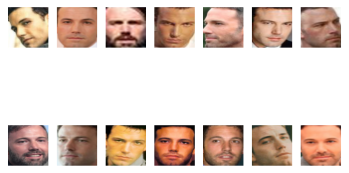

In [36]:
folder = './data/train/Aishwarya_Rai/'
i = 1
# 遍历文件
for filename in listdir(folder):
    # 图片路径
    path = folder + filename
    # 获取人脸
    face = extract_face(path)
    print(i, face.shape)
    # 绘图
    plt.subplot(2, 7, i)
    plt.axis('off')
    plt.imshow(face)
    i += 1
plt.show()

In [37]:
# 每张人脸都被正确地检测到了，并且我们在检测到的人脸中有不同的光照、肤色和方向
# 接下来，我们对train和val文件夹中的每个子目录都进行类似的处理，提取出人脸，并为每个检测到的人脸准备一个以名称作为输出标签的数据集。
# 代码封装成函数

# 从目录中检测出人脸
def load_faces(directory):
    faces  =  list()
    for filename in listdir(directory):
        # 图片路径
        path = directory + filename
        # 获取人脸
        face = extract_face(path)
        # 保存
        faces.append(face)
    return faces

In [38]:
# 把输入的人脸作为X，标签作为y
def load_dataset(directory):
    # 一开始是列表格式
    X, y = list(), list()
    for subdir in listdir(directory):
        print(subdir)
        # 路径
        path = directory + subdir + '/'
        # 跳过一些非子目录的文件，如果有的话
        from os.path import isdir
        if not isdir(path):
            continue
        # 载入子目录中的人脸
        faces = load_faces(path)
        # 以子目录作为标签
        labels = [subdir for _ in range(len(faces))]
        # 加入X和y
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

ben_afflek
elton_john
jerry_seinfeld
madonna
mindy_kaling
(93, 160, 160, 3) (93,)
ben_afflek
elton_john
jerry_seinfeld
madonna
mindy_kaling
(25, 160, 160, 3) (25,)


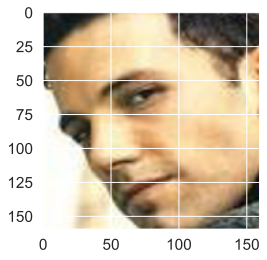

In [39]:
# train
trainX, trainy = load_dataset('./data/train/')
print(trainX.shape, trainy.shape)

# 显示一张图片
plt.imshow(trainX[0])

trainy[0]

# vali
testX, testy = load_dataset('./data/val/')
print(testX.shape, testy.shape)

# 把结果保存成numpy的npz格式的文件，方便下次调用
np.savez_compressed('./data.npz', trainX, trainy, testX,  testy)

#### **人脸嵌入**

**FaceNet简介**

FaceNet是Florian Schroff等人在Google于2015年发表的论文“ FaceNet: A Unified Embedding for Face Recognition and Clustering”（《FaceNet：人脸识别与聚类的统一嵌入》）中描述的一种人脸识别系统。给定一张人脸的图片，系统就将从人脸中提取出高质量的特征，并预测128个元素向量表示这些特征，称为人脸嵌入。所谓提取高质量特征，其实很类似PCA。

FaceNet可以直接学习从人脸图像到紧凑的欧几里得空间的映射，其中距离直接对应于人脸相似性的度量。该模型是通过三重损失函数训练的深度卷积神经网络，鼓励相同身份的向量变得更相似（距离更小），而不同身份的向量预期变得更不相似（距离更大）。将重点放在训练模型来直接创建嵌入（而不是从模型的中间层提取嵌入），是这项工作中的一个重要创新。然后，将这些人脸嵌入作为在标准人脸识别基准数据集上训练分类器系统的基础，从而得到当时最先进的结果。

我们将使用Hiroki Taniai提供的预训练Keras FaceNet模型，它是在MS-Celeb-1M数据集上训练的，并要求输入图像是彩色的，其像素值要进行标准化（在所有三个通道中进行标准化），并且具有160x160像素的正方形输入格式。

In [10]:
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [13]:
import h5py
f = h5py.File('./model/facenet_keras.h5', 'r')
f

<HDF5 file "facenet_keras.h5" (mode r)>

In [ ]:
import h5py

def print_structure(weight_file_path):
    """
    Prints out the structure of HDF5 file.
    Args:
      weight_file_path (str) : Path to the file to analyze
    """
    f = h5py.File(weight_file_path)
    try:
        if len(f.attrs.items()):
            print("{} contains: ".format(weight_file_path))
            print("Root attributes:")
        for key, value in f.attrs.items():
            print("  {}: {}".format(key, value))

        if len(f.items())==0:
            return 

        for layer, g in f.items():
            print("  {}".format(layer))
            print("    Attributes:")
            for key, value in g.attrs.items():
                print("      {}: {}".format(key, value))

            print("    Dataset:")
            for p_name in g.keys():
                param = g[p_name]
                subkeys = param.keys()
                for k_name in param.keys():
                    print("      {}/{}: {}".format(p_name, k_name, param.get(k_name)[:]))
    finally:
        f.close()
 
try:
    print_structure('./model/facenet_keras.h5')
except:
    pass

In [17]:
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [15]:
# 使用load_model()函数直接在Keras中加载模型
from keras.models import load_model
# 载入模型
model = load_model('./model/facenet_keras.h5')
# 查看输入输出格式
print(model.inputs)
print(model.outputs)

# 这个模型确实期望将正方形彩色图像作为具有形状为160x160的输入，并将输出一个包含128个元素向量的人脸嵌入

ValueError: bad marshal data (unknown type code)

In [41]:
# 上面提取出的人脸数据集上，运用我们的FaceNet模型
data = np.load('data.npz')
trainX,  trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [ ]:
# 定义一个函数来获取每张人脸的嵌入

# 根据输入的模型和人脸，获取嵌入表示
def get_embedding(model, face_pixels):
    # 进行标准化操作
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # 扩展维数，使人脸数组成为一个样本
    samples = np.expand_dims(face_pixels, axis=0)
    # 调用模型获取嵌入的结果
    yhat = model.predict(samples)
    return yhat[0]

# 接下来我们就可以把训练数据中的人脸表示为嵌入的形式
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX  =  np.asarray(newTrainX)
print(newTrainX.shape)

# 同样将测试数据中的人脸表示为嵌入的形式
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)


np.savez_compressed('data-embeddings.npz', newTrainX, trainy, newTestX, testy)

#### **人脸分类**

In [ ]:
data = np.load('data-embeddings.npz')
trainX, trainy, testX, testy =  data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

# 人脸嵌入向量进行归一化，使得向量的幅值为1
from sklearn.preprocessing import Normalizer
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)


# 将每个名人姓名的字符串目标变量转换为整数
from sklearn.preprocessing import LabelEncoder
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [ ]:
min(trainy)
max(trainy)

In [ ]:
# 使用SVM
model = SVC()
model.fit(trainX, trainy)

from sklearn.metrics import accuracy_score
# 预测
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# 评估准确率
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# 打印结果
print('Accuracy: train=%.3f, test=%.3f'  %  (score_train*100,  score_test*100))
# 可以看到在这个数据集上，我们可以取得100%的准确率